# Atividade 01 - Criando objetos MNE

Dennis Felipe Urtubia e Pedro Perozin

# Carregamento dos dados, labels e descritor

In [1]:
import numpy as np
import json
import mne
import matplotlib

data = np.load('files/data.npy')
labels = np.load('files/labels.npy')

desc_file = open('files/descriptor.json')
descriptor = json.loads(desc_file.read())
desc_file.close()

print('Estruturas => dados', data.shape, 'labels', labels.shape)
print(labels)

Estruturas => dados (125, 257, 1205) labels (125,)
[4 2 3 5 1 2 5 4 2 3 1 5 4 3 2 4 1 2 5 3 4 1 3 1 3 4 2 3 5 1 2 5 4 2 3 1 5
 4 3 2 4 1 2 5 3 4 1 3 1 3 4 2 3 5 1 2 5 4 2 3 1 5 4 3 2 4 1 2 5 3 4 1 3 1
 3 4 2 3 5 1 2 5 4 2 3 1 5 4 3 2 4 1 2 5 3 4 1 3 1 3 4 2 3 5 1 2 5 4 2 3 1
 5 4 3 2 4 1 2 5 3 4 1 3 1 3]


# Criação do EpochsArray

In [2]:
data = data[:,:256,:]

trial_duration = 5
sampling_frequency = data.shape[-1] / trial_duration
montage = mne.channels.make_standard_montage('EGI_256')
ch_names = data.shape[1]
ch_types = 'eeg'

# primeiramente devemos criar o objeto info
info = mne.create_info(montage.ch_names, sampling_frequency, ch_types)

#set experiments montage
info.set_montage(montage)

# por fim a criação do EpochsArray
events = np.array([[index, 0, event] for index, event in enumerate(labels)])
epoch = mne.EpochsArray(data, info, events)

print()

125 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped



# Plot de gráficos

EGI 256
Creating RawArray with float64 data, n_channels=256, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


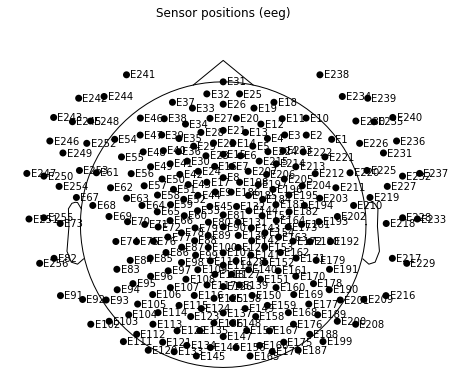

Setting up band-pass filter from 5 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 399 samples (1.656 sec)

    Using multitaper spectrum estimation with 7 DPSS windows


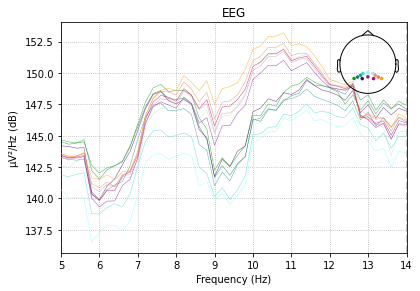

    Using multitaper spectrum estimation with 7 DPSS windows


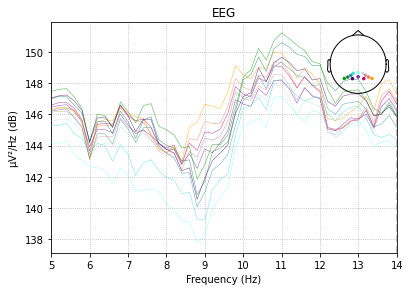

    Using multitaper spectrum estimation with 7 DPSS windows


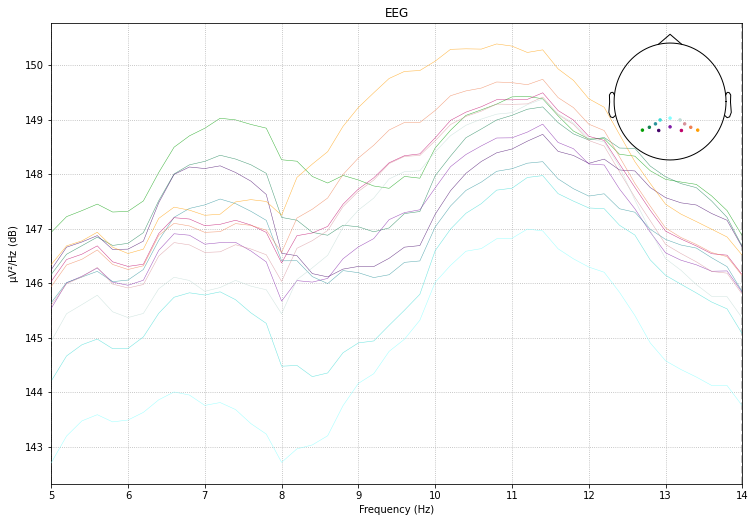

In [3]:
# plotando o padrão EGI 256
print('EGI 256')
montage.plot()

# Filtrando apenas dados dos eletrodos O1, Oz e O2
filtered_epoch = epoch.copy().pick_channels(['E116', 'E126', 'E150','E106','E107','E108','E109','E119','E140','E151','E160','E169'])

filtered_epoch.filter(l_freq = 5.0, h_freq = 14.0)

e = '4'

for i in range(2):
    filtered_epoch[e][i].plot_psd(fmin=5., fmax=14.)

matplotlib.rcParams['figure.figsize'] = [12., 8.]
filtered_epoch[e].plot_psd(fmin = 5., fmax = 14.)
print()

In [4]:
epoch.save('files/ssvep-epo.fif', overwrite=True)

# Features

In [5]:
epochs = mne.read_epochs('files/ssvep-epo.fif')
# filtranndo apenas alguns canais
epochs.pick_channels(['E116', 'E126', 'E150','E106','E107','E108','E109','E119','E140','E151','E160','E169'])
print(epochs)

Reading files/ssvep-epo.fif ...
    Found the data of interest:
        t =       0.00 ...    4995.85 ms
        0 CTF compensation matrices available
125 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
<EpochsFIF  |   125 events (all good), 0 - 4.99585 sec, baseline off, ~14.0 MB, data loaded,
 '1': 25
 '2': 25
 '3': 30
 '4': 25
 '5': 20>


In [7]:
from scipy.signal import stft

# extraindo somente os dados do objeto MNE
data = epochs.get_data()
print(data.shape) # domínio do tempo

# aplicando STFT
_, _, w = stft(data, fs=241, nperseg=32, noverlap=16)
# w = np.swapaxes(w, 3, 4)
print(w.shape)

(125, 12, 1205)
(125, 12, 17, 77)


In [8]:
W = np.abs(w) ** 2
# w = np.reshape(w, (125, 13, 17 * 77)) # <= questão de projeto
# w = w.transpose(0, 2, 1)
# w = np.reshape(w, (125 * 1309, 13))
print(W.shape)

# shape resultante: (125, 13, 17, 77)

(125, 12, 17, 77)
